Bring in the RLBench BC data from the saved hdf5 data files for each task. The task files were created with the instructRL/data/collect_data.py script. The task files include an array of data samples.  Each sample is a dict that includes the following keys:

* image - data for 4 camera positions: front_rgb, left_shoulder_rgb, right_shoulder_rgb, wrist_rgb
* instruct - the text instruction
* action - the action vector: [p;q;g] where for RLBench the gripper state is a single scalar open or closed [1,0]

In [1]:
from getdata import RLBenchDataset
import torch


# Read in the RLBench training data.  The RLBenchDataset class is a subclass of the PyTorch Dataset class.
batch_size = 50

# Load the training dataset and create a PyTorch DataLoader object.
train_dataset = RLBenchDataset(
    update=None,
    dataset_name="reach_target",
    start_offset_ratio=None,
    split="train",
)

train_loader = torch.utils.data.DataLoader(    
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0)

# Load the validation dataset and create a PyTorch DataLoader object.
val_dataset = RLBenchDataset(
    update=None,
    dataset_name="reach_target",
    start_offset_ratio=None,
    split="val",
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0)

In [2]:
print(f"Training dataset batch info:")
for i, (data, target) in enumerate(train_loader):
    print("action:", data['action'].shape)
    print("encoder_emb:", data['encoder_emb'].shape)
    print("target:", target.shape)
    break
print("num batches: " + str(len(train_loader)))

print(f"Val dataset batch info:")
for i, (data, target) in enumerate(val_loader):
    print("action:", data['action'].shape)
    print("encoder_emb:", data['encoder_emb'].shape)
    print("target:", target.shape)
    break
print("num batches: " + str(len(val_loader)))
print(data['action'].shape)


Training dataset batch info:
action: torch.Size([50, 3, 8])
encoder_emb: torch.Size([50, 2, 768])
target: torch.Size([50, 2, 8])
num batches: 26
Val dataset batch info:
action: torch.Size([50, 3, 8])
encoder_emb: torch.Size([50, 2, 768])
target: torch.Size([50, 2, 8])
num batches: 10
torch.Size([50, 3, 8])


In [3]:
from torch import nn, Tensor
import math

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 500):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        # even indices are sine, odd indices are cosine
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[ batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

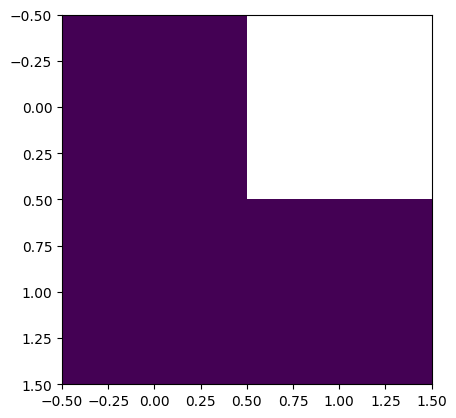

tensor([[0., -inf],
        [0., 0.]])


In [4]:
import matplotlib.pyplot as plt

lk = nn.Transformer.generate_square_subsequent_mask(2)
# plot the attention mask
plt.imshow(lk.numpy())
plt.show()
print(lk)


In [5]:

from torch.nn import TransformerDecoder, TransformerDecoderLayer

class ActionDecoderModel(nn.Module):

    def __init__(self, action_dim: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5, action_seq_len: int = 5,
                 mem_seq_len: int = 5):
        super().__init__()
        self.pos_encoder = PositionalEncoding(d_model, dropout=0, max_len=action_seq_len)
        decoder_layer = TransformerDecoderLayer(d_model, nhead, d_hid, dropout, batch_first=True)
        self.transformer_decoder = TransformerDecoder(decoder_layer, nlayers)
        self.d_model = d_model
        self.linear_action_in = nn.Linear(action_dim, d_model)
        # The output of the transformer decoder is a sequence of length action_seq_len-1 because it doesn't have sos token
        self.linear_action_out = nn.Linear(d_model, action_dim)
        self.tgt_mask = nn.Transformer.generate_square_subsequent_mask(action_seq_len)
        self.mem_mask = nn.Transformer.generate_square_subsequent_mask(mem_seq_len)
   

    def forward(self, actions: Tensor, memory: Tensor) -> Tensor:
        """
        
        """
        actions = self.linear_action_in(actions)
        actions = self.pos_encoder(actions)
        # If mixing tasks, then we will need padding masks in the batch
        output = self.transformer_decoder(
            tgt=actions, 
            memory=memory, 
            tgt_is_causal=True, 
            memory_is_causal=True,
            tgt_mask=self.tgt_mask,
            memory_mask=self.mem_mask
            )
        
        output = self.linear_action_out(output)
        return output

In [6]:

# max number of tokens in encoder embeddings for the training tasks in a batch. Can be constant if all same task, otherwise needs to be computed. Also determines whether a padding mask must be applied.  Determines the size of the causal mask and max
# max sequence length of the decoder action sequence and target output sequence. Decoder input size is seq_len + 2 to account for the start of sequence (sos) and end of sequence (eos) tokens.
action_seq_len = 1 + 2  # sos + action + eos
obs_seq_len = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
action_dim = 8 # feature length of the action vector [p;q;g]
mm_dim = 768  # embedding dimension of the encoder (768,)
d_hid = 768  # dimension of the feedforward network model in ``nn.TransformerDecoder``
nlayers = 2  # number of nn.TransformerDecoderLayer in nn.TransformerDecoder
nhead = 2  # number of attention heads in nn.MultiheadAttention
dropout = 0.2  # dropout probability
model = ActionDecoderModel(
    action_dim=action_dim, 
    d_model = mm_dim, 
    nhead = nhead, 
    d_hid = d_hid, 
    nlayers = nlayers, 
    dropout = dropout, 
    action_seq_len = action_seq_len,
    mem_seq_len = obs_seq_len,
    ).cuda()

In [7]:
# print whether model is on GPU or CPU
print(f"Model is on {next(model.parameters()).device}")

# Display the model architecture and number of trainable parameters
print(model)

Model is on cuda:0
ActionDecoderModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=768, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
 

In [8]:
import time
import numpy as np

loss_fn = nn.MSELoss(
    reduction='mean'
)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.01,
    betas=(0.9, 0.999),
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer, 
    gamma=0.9,
    verbose=True
)

epochs = 10 # The number of epochs
# Create a 2D array of zeros to store the training loss for each epoch.
train_loss_buf = np.zeros((epochs, len(train_loader)))

def train(model: nn.Module) -> None:
    model.train()
    log_interval_loss = 0.
    start_time = time.time()

    for i, (batch, targets) in enumerate(train_loader):
        
        encoder_embeddings = batch['encoder_emb'].cuda()
        action_inputs = batch['action'].cuda()
        optimizer.zero_grad()
        outputs = model(actions=action_inputs, memory=encoder_embeddings)
        targets = torch.squeeze(targets).cuda()
        # Compare target sequence to output sequence, ignoring the sos token
        batch_train_loss = loss_fn(outputs[:,1:,:], targets)
        batch_train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        log_interval_loss += batch_train_loss.item()
        train_loss_buf[epoch-1, i] = batch_train_loss.item()
        log_interval = 10
        if i % log_interval == 0 and i >= 0:
            cur_loss = log_interval_loss / log_interval
            elapsed = time.time() - start_time
            print(f'| epoch: {epoch:3d} | {i+1:5d}/{len(train_loader):5d} batches | '
                  f'lr: {scheduler.get_last_lr()[0]:02.3f} | ms/batch: {elapsed * 1000 / log_interval:5.2f} | '
                  f'log batch loss: {log_interval_loss:1.5f} | ')
            log_interval_loss = 0
            start_time = time.time()
        
        

Adjusting learning rate of group 0 to 1.0000e-02.


In [9]:


def evaluate(model: nn.Module, val_loader: iter) -> float:
    model.eval()  # turn on evaluation mode
    total_val_loss = 0.
    with torch.no_grad():
        for i, (batch, targets) in enumerate(train_loader):
            encoder_embeddings = batch['mm_embeddings'].cuda()
            action_inputs = batch['action'].cuda()
            targets = torch.squeeze(targets).cuda()
            output = model(actions=action_inputs, memory=encoder_embeddings)
            batch_val_loss = loss_fn(output, targets)
            total_val_loss += batch_val_loss.item()
            
    return np.mean(total_val_loss, dtype=np.float32)

In [10]:


for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train(model)
       # val_loss = evaluate(model, val_loader)
        scheduler.step()
        elapsed = time.time() - epoch_start_time
        print('-' * 89)
        print(f'| end of epoch: {epoch:3d} | epoc time: {elapsed:5.2f}s | ')
        print('-' * 89)
        

| epoch:   1 |     1/   26 batches | lr: 0.010 | ms/batch: 55.09 | log batch loss: 0.52343 | 
| epoch:   1 |    11/   26 batches | lr: 0.010 | ms/batch: 112.71 | log batch loss: 53.24119 | 
| epoch:   1 |    21/   26 batches | lr: 0.010 | ms/batch: 107.91 | log batch loss: 9.50702 | 
Adjusting learning rate of group 0 to 9.0000e-03.
-----------------------------------------------------------------------------------------
| end of epoch:   1 | epoc time:  3.23s | 
-----------------------------------------------------------------------------------------
| epoch:   2 |     1/   26 batches | lr: 0.009 | ms/batch: 10.79 | log batch loss: 0.60272 | 
| epoch:   2 |    11/   26 batches | lr: 0.009 | ms/batch: 114.30 | log batch loss: 5.00982 | 
| epoch:   2 |    21/   26 batches | lr: 0.009 | ms/batch: 108.10 | log batch loss: 4.19241 | 
Adjusting learning rate of group 0 to 8.1000e-03.
-----------------------------------------------------------------------------------------
| end of epoch:   

In [ ]:
#    print(f'| end of epoch: {epoch:3d} | epoc time: {elapsed:5.2f}s | '
     #         f'valid loss: {val_loss:5.2f} | valid ppl: {np.exp(np.min([val_loss,10])):8.2f}')

In [ ]:
from datetime import date
import matplotlib.pyplot as plt

# plot the training loss for each epoch
plt.plot(np.log(np.transpose(train_loss_buf)))
plt.xlabel('Batch')
plt.ylabel('Log Training loss')

# add a legend
plt.legend(['Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5'])
plt.show()

# save the image to disk with the current date in the name of the file to the /home/levi directory
today = date.today()
fig1 = plt.gcf()
#fig1.savefig(f'/home/levi/transformer_training_loss_{today}.jpg')
